In [5]:
import mysql.connector as mysql
from mysql.connector import Error
import sqlite3
import numpy as np
import pandas as pd

### DATA PREPROCESSING

In [10]:
# Nhận tất cả dữ liệu thô từ database

try:
    connection = mysql.connect(host='localhost', database='air_quality', user='root', password='password')
    if connection.is_connected():
        cursor = connection.cursor()
        sql = "select * from air_quality_raw"
        cursor.execute(sql)
        record = cursor.fetchall()
        print('Kích thước dữ liệu: ', len(record))
        connection.commit()
        cursor.close()
except Error as e:
    print('Error', e)

Error Authentication plugin 'caching_sha2_password' is not supported


In [15]:
# Chuyển dữ liệu sang dạng DataFrame
# df = pd.DataFrame(record, columns=['ID', 'City', 'Date', 'PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2', 'O3',
#                                    'Benzene', 'Toluene', 'Xylene', 'AQI', 'AQI_Bucket'])
df = pd.read_csv('../airquality/city_day.csv')
# df = df.drop(columns=['ID'])

NameError: name 'record' is not defined

In [ ]:
df = df.drop(columns=['City', 'Date', 'AQI_Bucket', 'Xylene', 'Benzene', 'SO2'])
df.head()

,PM2.5,PM10,NO,NO2,NOx,NH3,CO,O3,Toluene,AQI
0,NaN,NaN,0.92,18.22,17.15,NaN,0.92,133.36,0.02,NaN
1,NaN,NaN,0.97,15.69,16.46,NaN,0.97,34.06,5.50,NaN
2,NaN,NaN,17.40,19.30,29.70,NaN,17.40,30.70,16.40,NaN
3,NaN,NaN,1.70,18.48,17.97,NaN,1.70,36.08,10.14,NaN
4,NaN,NaN,22.10,21.42,37.76,NaN,22.10,39.31,18.89,NaN


In [ ]:
# Bỏ các giá trị trống
df = df.dropna()
df.shape

(10960, 10)

### DATABASE CONNECTION

In [17]:
# Tạo database cho dữ liệu sau khi xử lý
try:
    connection = mysql.connect(host='localhost', database='air_quality', user='root', password='16042001')
    if connection.is_connected():
        cursor = connection.cursor()
        cursor.execute(
            'CREATE TABLE if not exists preprocessed_air_quality (ID int NOT NULL AUTO_INCREMENT PRIMARY KEY,`PM2.5` double,`PM10` double,`NO` double,`NO2` double,NOx double,`NH3` double,`CO` double,O3 double,Toluene double,AQI double)')
        print('New table was created')
        connection.commit()
        cursor.close()
except Error as e:
    print('Error', e)

Error Authentication plugin 'caching_sha2_password' is not supported


In [ ]:
# Import records of corr_matrix into database
try:
    connection = mysql.connect(host='localhost', database='air_quality', user='root', password='cuong#Super2001')
    if connection.is_connected():
        cursor = connection.cursor()
        for i, row in df.iterrows():
            sql = "INSERT INTO preprocessed_air_quality(`PM2.5`,`PM10`,`NO`,`NO2`,NOx,`NH3`,`CO`,O3,Toluene,AQI) VALUES (%s,%s,%s,%s,%s,%s,%s,%s,%s,%s)"
            cursor.execute(sql, tuple(row))
            # print('Inserted record')
        connection.commit()
        cursor.close()
except Error as e:
    print('Error', e)

In [ ]:
# Nếu đã tồn tại, có thể xóa để tạo một database khác

# try:
#     connection = mysql.connect(host='localhost', database='air_quality', user='root', password='cuong#Super2001')
#     if connection.is_connected():
#         cursor = connection.cursor()
#         tbl_name = "preprocessed_air_quality"
#         sql = "drop table if exists " + tbl_name
#         cursor.execute(sql)
#         print('Table was dropped')
#         connection.commit()
#         cursor.close()
# except Error as e:
#     print('Error', e)


Table was dropped


# Corr

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [19]:
df = pd.read_csv('city_day.csv')
df = df.dropna()
df.shape

(6236, 16)

In [20]:
def get_full_corr(dataset): # In ra ma trận hệ số corr với tất cả các hàng cột của data (>< 1m10s)
    # remove object type
    drop_col = []
    for i in dataset.columns:
        if dataset[i].dtypes == object:
            drop_col.append(i)
    dataset = dataset.drop(columns = drop_col)

    list_cov_x_y = []
    len_col = len(dataset.columns)
    len_row = len(dataset)
    labels = list(dataset.columns)
    print(labels)
    #COV(x, y)
    for i in range(0,len_col):
        cov_feat = []
        i_mean = dataset.iloc[:,i].mean()
        for k in range(0, len_col):
            cov_x_y = 0.0
            k_mean = dataset.iloc[:,k].mean()
            for j in range(0,len_row):
                cov_x_y += (dataset.iloc[j,i]-i_mean)*(dataset.iloc[j,k]-k_mean)
            cov_x_y /= len_row
            cov_feat.append(cov_x_y)
        list_cov_x_y.append(cov_feat)
    print(len(list_cov_x_y))
    #COV(x)
    list_cov_x = []
    for i in range(0,len_col):
        i_mean = dataset.iloc[:,i].mean()
        cov_x = 0.0
        for j in range(0,len_row):
            cov_x += (dataset.iloc[j,i]-i_mean)**2
        cov_x /= (len_row-1)
        list_cov_x.append(cov_x**0.5)
    #COV(y)
    list_cov_y = []
    for i in range(0,len_col):
        cov_y_feat = []
        for k in range(0, len_col):
            cov_y = 0.0
            k_mean = dataset.iloc[:,k].mean()
            for j in range(0,len_row):
                cov_y += (dataset.iloc[j,k]-k_mean)**2
            cov_y /= (len_row-1)
            cov_y_feat.append(cov_y**0.5)
        list_cov_y.append(cov_y_feat)
    #CORR(x,y)
    list_corr = []
    for i in range(0,len_col):
        tmp_list = []
        for j in range(0, len_col):
            tmp_list.append(list_cov_x_y[i][j]/(list_cov_x[i]*list_cov_y[i][j]))
        list_corr.append(tmp_list)
    #CREATE CORR DATAFRAME
    list_corr = pd.DataFrame(list_corr, columns=labels)
    labels = pd.Index(labels)
    list_corr = list_corr.set_index(labels)
    return list_corr

['PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2', 'O3', 'Benzene', 'Toluene', 'Xylene', 'AQI']
13


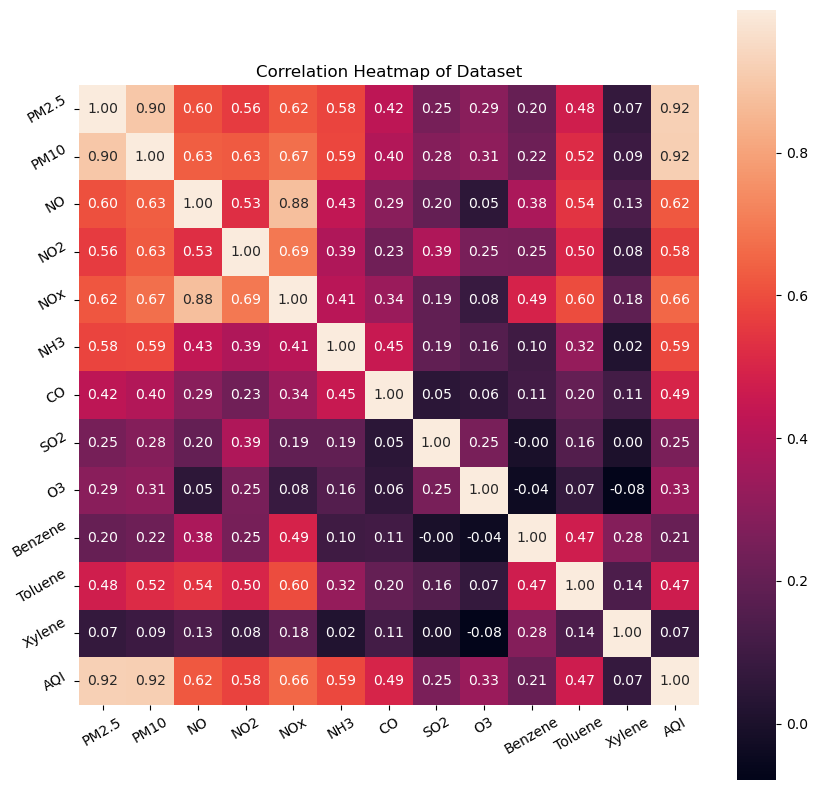

In [21]:
corr_matrix = get_full_corr(df)
plt.figure(figsize=(10, 10))
plt.title('Correlation Heatmap of Dataset')
a = sns.heatmap(corr_matrix, square=True, annot=True, fmt='.2f', linecolor='black')
a.set_xticklabels(a.get_xticklabels(), rotation=30)
a.set_yticklabels(a.get_yticklabels(), rotation=30)           
plt.show()

In [22]:
def get_corr(df): # In ra ma trận hệ số corr với duy nhất cột nhãn của data (>< 6.6s)
    # remove object type
    drop_col = []
    for i in df.columns:
        if df[i].dtypes == object:
            drop_col.append(i)
    df = df.drop(columns = drop_col)

    list_cov_x_y = []
    len_col = len(df.columns)
    len_row = len(df)
    labels = list(df.columns)
    print(labels)
    #COV(x, y)
    list_cov_x_y = []
    len_col = len(df.columns)
    len_row = len(df)
    print(len_col, len_row)
    y_mean = df.iloc[:,len_col-1].mean()
    for i in range(0,len_col):
        cov_x_y = 0.0
        x_mean = df.iloc[:,i].mean()
        for j in range(0,len_row):
            cov_x_y += (df.iloc[j,i]-x_mean)*(df.iloc[j,len_col-1]-y_mean)
        cov_x_y /= len_row
        list_cov_x_y.append(cov_x_y)
    #COV(x)
    list_cov_x = []
    for i in range(0,len_col):
        cov_x = 0.0
        x_mean = df.iloc[:,i].mean()
        for j in range(0,len_row):
            cov_x += (df.iloc[j,i]-x_mean)**2
        cov_x /= (len_row-1)
        list_cov_x.append(cov_x**0.5)
    #COV(y)
    list_cov_y = []
    y_mean = df.iloc[:,len_col-1].mean()
    for i in range(0,len_col):
        cov_y = 0.0
        for j in range(0,len_row):
            cov_y += (df.iloc[j,len_col-1]-y_mean)**2
        cov_y /= (len_row-1)
        list_cov_y.append(cov_y**0.5)
    #CORR(x,y)
    list_corr = []
    for i in range(0,len_col):
        list_corr.append(list_cov_x_y[i]/(list_cov_x[i]*list_cov_y[i]))
    #CREATE CORR DATAFRAME
    list_corr = pd.DataFrame(list_corr, columns=['Y'])
    labels = pd.Index(labels)
    list_corr = list_corr.set_index(labels)
    return list_corr

['PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2', 'O3', 'Benzene', 'Toluene', 'Xylene', 'AQI']
13 6236


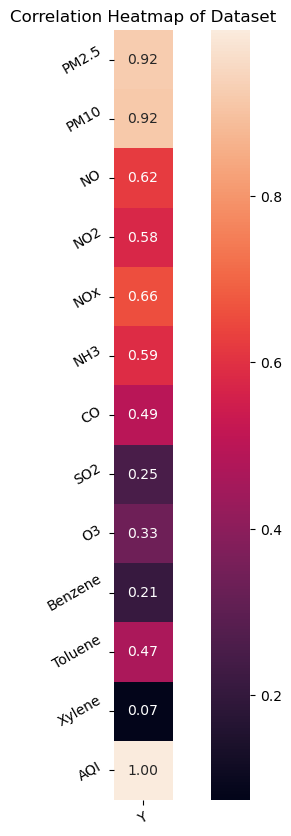

In [23]:
corr_matrix = get_corr(df)
plt.figure(figsize=(10, 10))
plt.title('Correlation Heatmap of Dataset')
a = sns.heatmap(corr_matrix, square=True, annot=True, fmt='.2f', linecolor='black')
a.set_xticklabels(a.get_xticklabels(), rotation=30)
a.set_yticklabels(a.get_yticklabels(), rotation=30)           
plt.show()  

In [24]:
def train_test_split(features, label_name, test_size, random_state):
    shuffle_feature_df = features.sample(frac = 1,random_state=random_state)
    test_size = int(test_size*len(features))
    X_train = shuffle_feature_df[test_size:]
    X_test = shuffle_feature_df[:test_size]
    y_train = X_train[label_name]
    y_test = X_test[label_name]
    X_train = X_train.drop(columns=[label_name])
    X_test = X_test.drop(columns=[label_name])
    return X_train, X_test, y_train, y_test

In [25]:
X = df.drop(columns=['City','Date','AQI_Bucket'])

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X,'AQI',test_size=0.95,random_state=1)

In [27]:
print(X_train.shape,' ',X_test.shape,' ',df.shape)

(312, 12)   (5924, 12)   (6236, 16)


In [28]:
X_train.head()

,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene
3062,12.74,30.83,1.66,10.27,6.81,9.45,0.59,13.28,34.95,0.13,0.77,0.15
2738,6.85,13.30,1.61,1.52,1.86,2.44,0.46,13.29,18.07,0.04,0.26,0.10
19755,42.51,62.04,5.02,11.91,16.97,17.94,0.56,7.73,59.02,2.23,5.97,0.43
11451,111.95,302.10,42.33,54.75,76.02,45.99,2.20,16.31,57.48,3.61,5.38,0.00
16539,24.12,56.89,6.46,23.33,16.59,10.57,0.34,5.38,27.84,1.34,9.90,0.82


# Decision Tree Regressor

In [29]:
class Node:
    
    def __init__(self, feature=None, threshold=None, left=None, right=None, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value
    
    def is_leaf_node(self):
        return self.value is not None

In [30]:
# Decision Tree Regressor Class
class RegressionTree:
    def __init__(self,max_depth = 15,min_samples_split = 10):
        self.root = None
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
    
    def fit(self, X, Y):
        self.n_feats = X.shape[1]
        self.col = list(X.columns)
        self.root = self.growTree(X, Y)

    def growTree(self, X, Y, depth = 0):
        df = X.copy()
        df['y'] = Y
        ymean = np.mean(Y)
        self.mse = self.get_mse(Y, ymean)
        n_sample = X.shape[0]
        # stopping criteria
        if depth >= self.max_depth or n_sample <= self.min_samples_split:
            leaf_value = np.mean(Y)
            return Node(value=leaf_value)
        best_feat, best_thresh = self.best_criteria(X, Y)
        left_df, right_df = df[df[best_feat]<=best_thresh].copy(), df[df[best_feat]>best_thresh].copy()
        left = self.growTree(left_df.drop('y', axis=1), left_df['y'].values.tolist(), depth+1)
        right = self.growTree(right_df.drop('y', axis=1), right_df['y'].values.tolist(), depth+1)
        return Node(best_feat, best_thresh, left, right)
    
    # find out best criteria
    def best_criteria(self, X, Y):
        df = X.copy()
        df['y'] = Y
        mse_base = self.mse
        best_feature = best_thresh = None
        for feat in X.columns:
            x_mean = self.moving_average(np.unique(df[feat]), 2)
            for value in x_mean:
                left_y = df[df[feat] <= value]['y'].values
                right_y = df[df[feat] > value]['y'].values
                left_mean = right_mean = 0
                if len(left_y) > 0:
                    left_mean = np.mean(left_y)
                if len(right_y) > 0:
                    right_mean = np.mean(right_y)
                
                res_left, res_right = left_y - left_mean, right_y - right_mean
                r = np.concatenate((res_left, res_right), axis=None)
                n = len(r)
                r = np.sum(r**2)
                mse_split = r / n
                if mse_split < mse_base:
                    mse_base = mse_split
                    best_feature = feat
                    best_thresh = value
        return (best_feature, best_thresh)
    
    def get_mse(self, y_true, y_hat):
        n = len(y_true)
        r = np.sum((y_true - y_hat)**2)
        return r / n
    
    def moving_average(self, x, window):
        return np.convolve(x, np.ones(window), 'valid') / window 
    
    def predict(self, X):
        X = X.to_numpy().tolist()
        return np.array([self.traverse_tree(x, self.root) for x in X])

    def traverse_tree(self, x, node):
        if node.value is not None:
            return node.value
        fr = node.feature
        index = self.col.index(fr)
        if x[index] <= node.threshold:
            return self.traverse_tree(x, node.left)
        return self.traverse_tree(x, node.right)

# Random Forest

In [ ]:
class RandomForest:
    def __init__(self, trees, n_trees, max_feature, prediction_aggrigation_calculation):
        self.n_estimators = n_trees
        self.max_features = max_feature
        self.tree_feature_indexes = []
        self.prediction_aggrigation_calculation = prediction_aggrigation_calculation 
        self.trees = trees

    def _make_random_suset(self, X, y, n_subsets, replasment=True):
        subset = []
        sample_size = (X.shape[0] if replasment else (X.shape[0] // 2))
        
        X = X.to_numpy()
        y = y.to_numpy()
        y = np.reshape(y, (len(y),1))
        Xy = np.concatenate((X, y), axis=1)

        np.random.shuffle(Xy)
        for i in range(n_subsets):
            index = np.random.choice(range(sample_size), size=np.shape(range(sample_size)), replace=replasment)
            X = Xy[index][:, :-1]
            y = Xy[index][: , -1]
            subset.append({"X" : X, "y": y})
        return subset

    def train(self, X, y):
        n_features = X.shape[1]
        name_columns = list(X.columns)
        
        if self.max_features == None:
            self.max_features = int(math.sqrt(n_features))

        subsets = self._make_random_suset(X, y, self.n_estimators)

        for i, subset in enumerate(subsets):
            X_subset , y_subset = subset["X"], subset["y"]
            idx = np.random.choice(range(n_features), size=self.max_features, replace=False)

            self.tree_feature_indexes.append(idx)
            X_subset = X_subset[:, idx]
            selected_name_columns = []
            # print(idx)
            for j in range(len(idx)):
                selected_name_columns.append(name_columns[idx[j]])
            selected_name_columns.append('Y')
            y_subset = np.expand_dims(y_subset, axis =1)
            Xy_subset = np.concatenate((X_subset, y_subset), axis=1)
            Xy_subset = pd.DataFrame(Xy_subset, columns=selected_name_columns)
            print(Xy_subset.head())
            X_set = Xy_subset.drop(columns=['Y'])
            y_set = Xy_subset['Y']
            self.trees[i].fit(X_set, y_set)

    def predict(self, test_X):
        y_preds = np.empty((test_X.shape[0], self.n_estimators))
        for i, tree in enumerate(self.trees):
            features_index = self.tree_feature_indexes[i]
            col_name = list(test_X.columns)
            selected_col_name = []
            for j in features_index:
                selected_col_name.append(col_name[j])
            X_selected_features = test_X[selected_col_name]
            print(X_selected_features)
            y_preds[:, i] = tree.predict(X_selected_features)
        y_pred = self.prediction_aggrigation_calculation(y_preds)

        return y_pred

In [ ]:
class RandomForestRegression(RandomForest):
    def __init__(self, max_feature, max_depth, n_trees=100, min_sample_split=10):
        self.prediction_aggrigation_calculation = self._mean_calculation
        self.trees = []
        for _ in range(n_trees):
            self.trees.append(RegressionTree(min_samples_split=min_sample_split, max_depth=max_depth))

        super().__init__(trees=self.trees, n_trees=n_trees,max_feature=max_feature,
                         prediction_aggrigation_calculation=self.prediction_aggrigation_calculation)
    
    def _mean_calculation(self, y_preds):
        y_pred = np.empty((y_preds.shape[0], 1))
        for i, sample_predictions in enumerate(y_preds):
            y_pred[i] = np.mean(sample_predictions)

        return y_pred

# Lasso Regression

# Linear Regression

# KNeighbors Regressor